In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Market Price Estimation

### EDA

In [2]:
df_raw = pd.read_csv("auctions.csv")

In [3]:
df = df_raw.copy()

In [4]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2/1/2012,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,1/1/2018
1,BMW,M4,13929,317,4/1/2016,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2/1/2018
2,BMW,320,183297,120,4/1/2012,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2/1/2018
3,BMW,420,128035,135,7/1/2014,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2/1/2018
4,BMW,425,97097,160,12/1/2014,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,4/1/2018


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price              4843 non-null   int64 


In [22]:
columns = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']

In [41]:
def description(columns):
    result = []
    for column in columns:
        result.append(f"There are {df[column].nunique()} different {column}s.\n")
    return result

descriptions = description(columns)
for desc in descriptions:
    print(desc)

There are 1 different maker_keys.

There are 75 different model_keys.

There are 4 different fuels.

There are 10 different paint_colors.

There are 8 different car_types.



In [42]:
df.columns

Index(['maker_key', 'model_key', 'mileage', 'engine_power',
       'registration_date', 'fuel', 'paint_color', 'car_type', 'feature_1',
       'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'price', 'sold_at'],
      dtype='object')

In [54]:
mets = ['mileage', 'engine_power', 'registration_date', 'price',
       'sold_at', 'model_key', 'fuel', 'paint_color', 'car_type']

/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_2617/3405001104.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_2617/3405001104.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_2617/3405001104.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_2617/3405001104.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_2617/3405001104.py:10: UserWarning: FixedFormatter should only be used together with Fixe

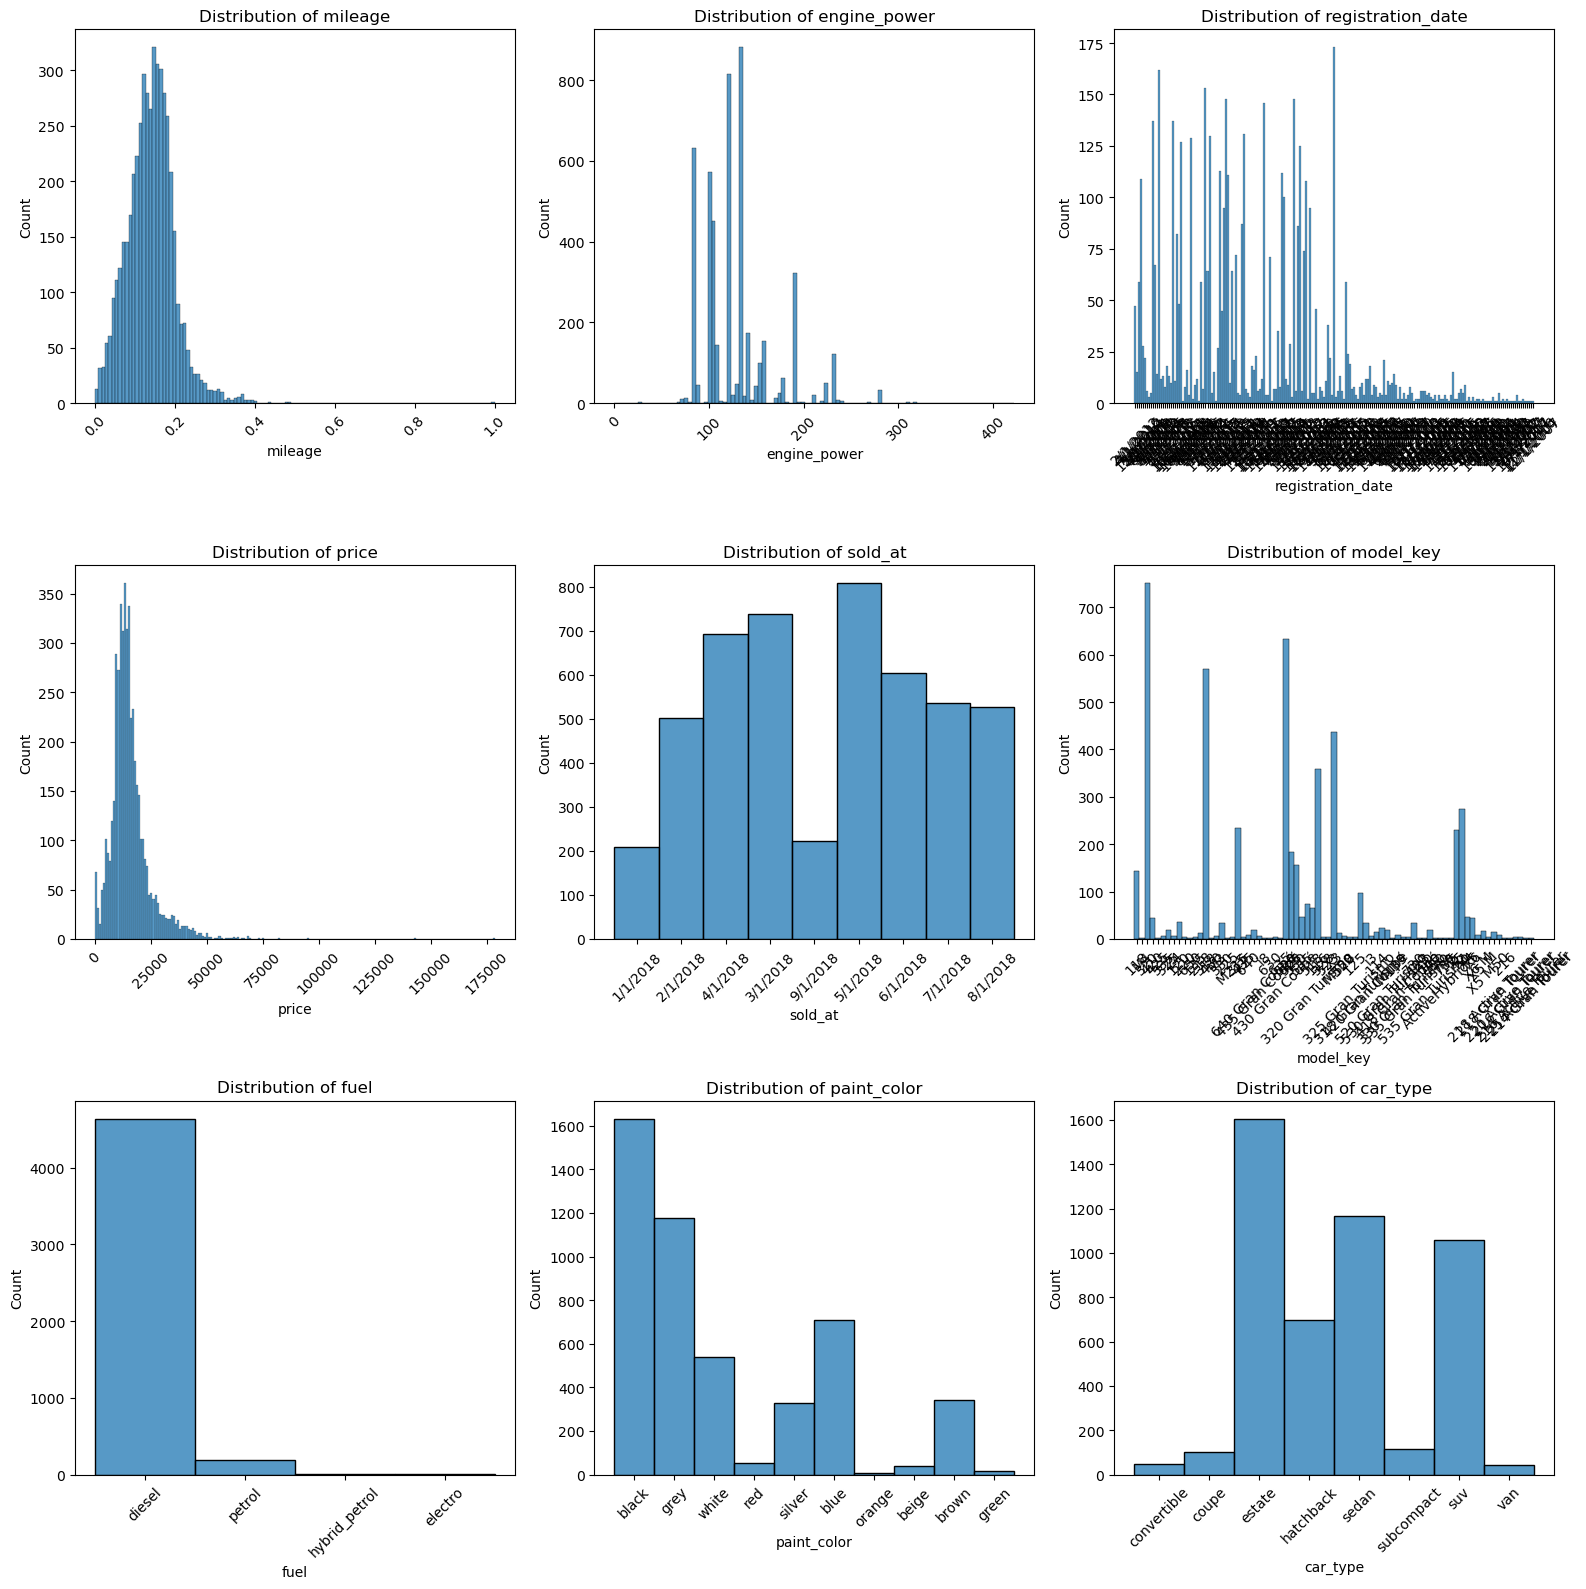

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))

axes = axes.flatten()


for i, metric in enumerate(mets):
    ax = axes[i]
    sns.histplot(data=df, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()